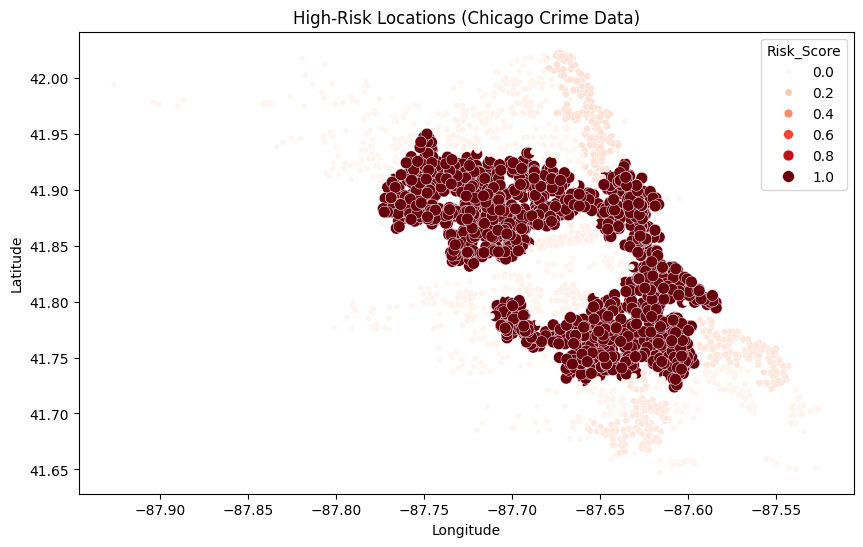

AttributeError: 'DBSCAN' object has no attribute 'predict'

In [ ]:
# Jupyter Notebook: Risky Location Model for Personal Security Solution

# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and preprocess crime data
# Using Chicago Crime Data as a proxy (replace with Knoema Tunisia data when available)
# Download from: https://catalog.data.gov/dataset/crimes-2001-to-present
# For this example, assume a CSV with columns: 'Latitude', 'Longitude', 'Primary Type', 'Date'
url = 'https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD'
df = pd.read_csv(url, usecols=['Latitude', 'Longitude', 'Primary Type', 'Date'], nrows=10000)  # Limit rows for speed

# Drop rows with missing coordinates
df = df.dropna(subset=['Latitude', 'Longitude'])

# Filter for violent crimes (e.g., assault, robbery)
violent_crimes = ['ASSAULT', 'BATTERY', 'ROBBERY', 'HOMICIDE']
df = df[df['Primary Type'].isin(violent_crimes)]

# Extract features: latitude and longitude
X = df[['Latitude', 'Longitude']].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply DBSCAN clustering to identify high-risk areas
dbscan = DBSCAN(eps=0.1, min_samples=10, metric='euclidean')  # Adjust eps based on data scale
clusters = dbscan.fit_predict(X_scaled)

# Add cluster labels to dataframe
df['Cluster'] = clusters

# Step 3: Assign risk scores
# Clusters with more points are riskier; -1 indicates noise (low risk)
cluster_counts = df[df['Cluster'] != -1]['Cluster'].value_counts()
df['Risk_Score'] = df['Cluster'].map(cluster_counts).fillna(0) / cluster_counts.max()  # Normalize to 0-1

# Step 4: Visualize results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Longitude', y='Latitude', hue='Risk_Score', size='Risk_Score', palette='Reds')
plt.title('High-Risk Locations (Chicago Crime Data)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [3]:

# Step 5: Function to predict risk score for new location
def predict_risk_score(lat, lon, model, scaler, cluster_counts):
    # Prepare input
    X_new = np.array([[lat, lon]])
    X_new_scaled = scaler.transform(X_new)
    
    # Predict cluster
    cluster = model.fit_predict(X_new_scaled)[0]
    
    # Assign risk score
    if cluster == -1:
        return 0.0
    else:
        return cluster_counts.get(cluster, 0) / cluster_counts.max()

# Example prediction
sample_lat, sample_lon = 41.8781, -87.6298  # Chicago downtown
risk_score = predict_risk_score(sample_lat, sample_lon, dbscan, scaler, cluster_counts)
print(f'Risk Score for ({sample_lat}, {sample_lon}): {risk_score:.2f}')

# Step 6: Save model for future use
import joblib
joblib.dump(dbscan, 'risky_location_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

Risk Score for (41.8781, -87.6298): 0.00


['scaler.pkl']